In [1]:
from examples.seismic import Receiver, Model, plot_velocity, demo_model, setup_geometry, AcquisitionGeometry

from examples.seismic.acoustic import acoustic_setup, AcousticWaveSolver
from examples.seismic.vector_reflectivity import vector_reflectivity_setup, VectorReflectivityAcousticWaveSolver
from examples.seismic.variable_density import VariableDensityAcousticWaveSolver

import numpy as np

from devito import norm, configuration, VectorTimeFunction, TimeFunction

import matplotlib.pyplot as plt

configuration['ignore-unknowns'] = 1

mpi4py is not available. You must install it


In [2]:
model = demo_model(preset='layers-isotropic', space_order=2, time_order=1, shape=(20, 25), spacing=(15., 15.), nbl=20, nlayers=2, dtype=np.float64, b=np.ones((20, 25)))

Operator `initdamp` ran in 0.01 s


In [3]:
rec_coordinates = np.empty((1, 2))
rec_coordinates[:, 0] = model.domain_size[0]/2
rec_coordinates[:, 1] = model.domain_size[1]/2

src_coordinates = np.empty((1, 2))
src_coordinates[0, 0] = model.domain_size[0]/2
src_coordinates[0, 1] = model.origin[-1] + model.spacing[-1]

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0=0.0, tn=500., src_type='Ricker', f0=0.010)

In [4]:
solver_acoustic = AcousticWaveSolver(model, geometry, space_order=model.space_order)
solver_vector_reflectivity = VectorReflectivityAcousticWaveSolver(model, geometry, space_order=model.space_order)
solver_variable_density = VariableDensityAcousticWaveSolver(model, geometry, space_order=model.space_order)

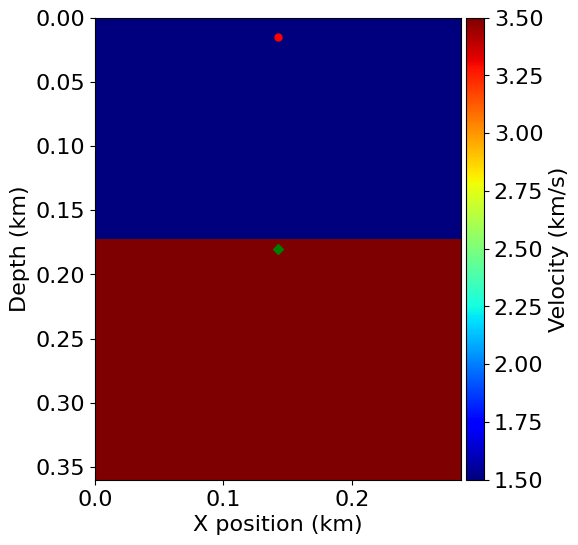

In [5]:
plot_velocity(solver_acoustic.model, solver_acoustic.geometry.src_positions, solver_acoustic.geometry.rec_positions)

In [6]:
rec_acoustic, u_acoustic, _ = solver_acoustic.forward(save=True)
rec_vector_reflectivity, u_vector_reflectivity, _ = solver_vector_reflectivity.forward(save=True)
rec_variable_density, u_variable_density, _ = solver_variable_density.forward(save=True)

Operator `Forward` ran in 0.01 s
Operator `Forward` ran in 0.01 s
Operator `Forward` ran in 0.01 s


In [7]:
nbl = model.nbl
u_acoustic.data[:, nbl:-nbl, nbl:-nbl].tofile('acoustic-forward.bin')
u_vector_reflectivity.data[:, nbl:-nbl, nbl:-nbl].tofile('vr-forward.bin')
u_variable_density.data[:, nbl:-nbl, nbl:-nbl].tofile('vd-forward.bin')
u_acoustic.data[:, nbl:-nbl, nbl:-nbl].shape,\
    u_vector_reflectivity.data[:, nbl:-nbl, nbl:-nbl].shape,\
    u_variable_density.data[:, nbl:-nbl, nbl:-nbl].shape

((192, 20, 25), (192, 20, 25), (192, 20, 25))

In [8]:
_, v_acoustic, _ = solver_acoustic.adjoint(rec_acoustic, save=True)
_, v_vector_reflectivity, _ = solver_vector_reflectivity.adjoint(rec_vector_reflectivity, save=True)
_, v_variable_density, _ = solver_variable_density.adjoint(rec_variable_density, save=True)

No source type defined, returning uninitiallized (zero) source
No source type defined, returning uninitiallized (zero) source
Operator `Adjoint` ran in 0.01 s
No source type defined, returning uninitiallized (zero) source
No source type defined, returning uninitiallized (zero) source
Operator `Adjoint` ran in 0.02 s
No source type defined, returning uninitiallized (zero) source
No source type defined, returning uninitiallized (zero) source
Operator `Adjoint` ran in 0.01 s


In [9]:
np.flip(v_acoustic.data[:, nbl:-nbl, nbl:-nbl], axis=0).tofile('acoustic-adjoint.bin')
np.flip(v_vector_reflectivity.data[:, nbl:-nbl, nbl:-nbl], axis=0).tofile('vr-adjoint.bin')
np.flip(v_variable_density.data[:, nbl:-nbl, nbl:-nbl], axis=0).tofile('vd-adjoint.bin')

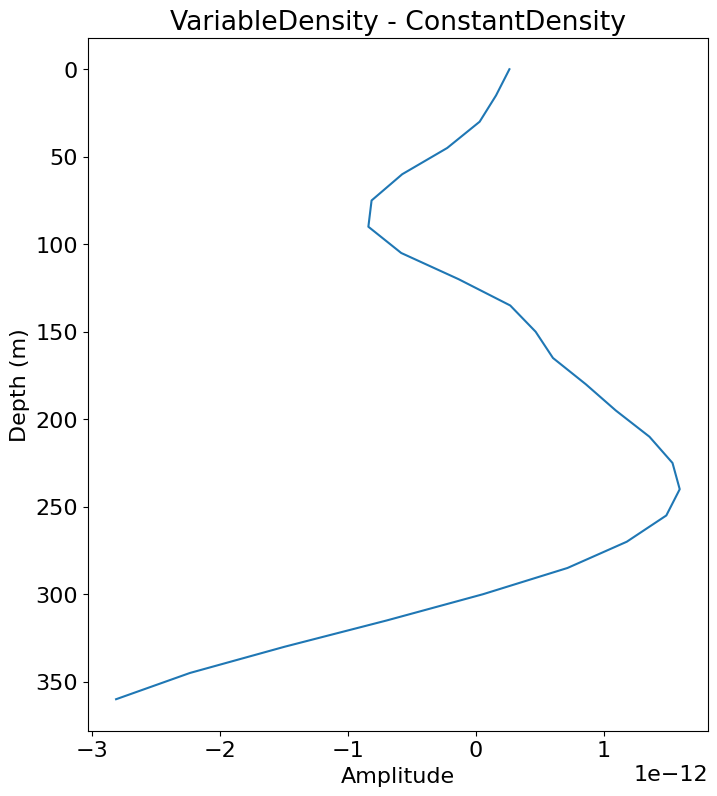

In [41]:
#NBVAL_SKIP
plt.figure(figsize=(8,9))
depth = np.linspace(0, solver_acoustic.model.domain_size[1], num=u_acoustic.data.shape[2] - 2*nbl)
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude')
plt.plot(u_variable_density.data[99, 10 + nbl, nbl:-nbl] - u_acoustic.data[99, 10 + nbl, nbl:-nbl], depth)
# plt.plot(u_vector_reflectivity.data[99, 10 + nbl, nbl:-nbl] - u_acoustic.data[99, 10 + nbl, nbl:-nbl],depth)
plt.title('VariableDensity - ConstantDensity')
# plt.title('VectorReflectivity - ConstantDensity')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

# ax[1].set_xlabel('Amplitude')
# ax[1].plot(u_vector_reflectivity.data[99, 10, :] - u_acoustic.data[99, 10, :],depth)
# ax[1].set_title('VectorReflectivity - ConstantDensity')
# ax[1].invert_yaxis()

# plt.plot(d_obs.data[:, 20],depth, 'm', label='Observed data')
# plt.legend(loc="upper left",fontsize=12)